# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.randint(1, 100)

46

# Импорт данных

Загрузим данные, обработанные в Модуле А.

In [3]:
columns_dict = {
    'VendorID': 'Int32',
    'tpep_pickup_datetime': 'object',
    'tpep_pickup_datetime': 'object',
    'passenger_count': 'Int32',
    'trip_distance': 'float32',
    'RatecodeID': 'Int32',
    'store_and_fwd_flag': 'object',
    'PULocationID': 'Int32',
    'DOLocationID': 'Int32',
    'payment_type': 'Int32',
    'fare_amount': 'float32',
    'extra': 'float32',
    'mta_tax': 'float32',
    'tip_amount': 'float32',
    'tolls_amount': 'float32',
    'improvement_surcharge': 'float32',
    'total_amount': 'float32',
    'congestion_surcharge': 'object',
}

In [4]:
taxi19 = pd.read_csv('data/taxi19_preprocess.csv', dtype=columns_dict)
taxi20 = pd.read_csv('data/taxi20_preprocess.csv', dtype=columns_dict)
taxi21 = pd.read_csv('data/taxi21_preprocess.csv', dtype=columns_dict)

Соеденим датасеты по годам для упрощения процесса кластеризации. <br>
Будет использовать только колонки, отобранные из модуля А.

In [5]:
sel_columns = ['payment_type', 'tolls_amount', 'total_amount', 'fare_amount', 'trip_distance', 'improvement_surcharge', 'day', 'month', 'year']
taxi = pd.concat([taxi19[sel_columns], taxi20[sel_columns], taxi21[sel_columns]])
taxi.head()

,payment_type,tolls_amount,total_amount,fare_amount,trip_distance,improvement_surcharge,day,month,year
0,1,0.0,13.560000,7.0,1.68,0.3,16,8,2019
1,2,0.0,19.799999,16.5,3.56,0.3,4,11,2019
2,2,0.0,8.300000,7.0,1.40,0.3,1,1,2019
3,2,0.0,13.300000,9.5,1.64,0.3,7,7,2019
4,1,0.0,14.300000,8.5,1.90,0.3,3,5,2019


In [6]:
# удалим из памяти ненужные данные
del taxi19, taxi20, taxi21

# 2.1 и 2.2 Построение аналитической системы

Аналитическая система построена и продемонстрирована в python-файле ```main.py``` в директории ```dashboard```

# 2.3 и 2.4 Кластеризация набора данных и вычисление показателей производительности кластеризации

Рассмотрим три модели кластеризации данных: <b>KMeans, MiniBatchKMeans и Birch.</b><br>
Выберем лучшую исходя из трех метрик: 
1. Индекс Дэвиса-Болдина.<b>

Этот индекс обозначает среднее «сходство» между кластерами, где сходство – это мера, которая сравнивает расстояние между кластерами с размером самих кластеров. Более низкий индекс Дэвиса-Болдина относится к модели с лучшим разделением кластеров.

2. Индекс Калинского-Харабаша<b>

Более высокий показатель индекса Калински-Харабаского относится к модели с более четко определенными кластерами.
Индекс представляет собой отношение суммы дисперсии между кластерами и дисперсии внутри кластера для всех кластеров

3. Коэффициент силуэта<br>

Коэффициент силуэта является примером такой оценки, где более высокий балл коэффициента силуэта относится к модели с более четко определенными кластерами. Коэффициент силуэта определяется для каждого образца и состоит из двух баллов:

## Предобработка данных

Вспользуемся методами предобработки данных из Модуля А для кластеризации.

In [7]:
transformer = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

X = pd.DataFrame(transformer.fit_transform(taxi), columns = transformer.get_feature_names_out())

# Удаляем выбросы, т.к. они плохо повляют на кластеризацию
mask = (X < 3).all(axis=1)
X = X[mask]
# Удаляем дату из данных
X = X.drop(['day', 'month', 'year'], axis=1)
X.head()

,payment_type,tolls_amount,total_amount,fare_amount,trip_distance,improvement_surcharge
0,-0.553045,-0.211379,-0.039624,-0.043618,-0.214554,0.059926
1,1.500324,-0.211379,0.002947,0.021304,0.079726,0.059926
2,1.500324,-0.211379,-0.075509,-0.043618,-0.258383,0.059926
3,1.500324,-0.211379,-0.041397,-0.026534,-0.220816,0.059926
4,-0.553045,-0.211379,-0.034575,-0.033368,-0.180117,0.059926


### Определим количество кластеров методом локтя

In [8]:
inertias = []
K = range(1, 10)

# Fit K-means for different values of k
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X.sample(frac=0.1))
    
    # Inertia is calculated directly by KMeans
    inertias.append(kmeanModel.inertia_)

print(inertias)

[6486746.213992132, 2190866.471723217, 1730292.873889726, 757473.8330259457, 606511.9513052369, 483700.13197402505, 353430.4168655803, 243991.93501708348, 197193.74389553835]


Text(0.5, 1.0, 'Межкластерное расстояние')

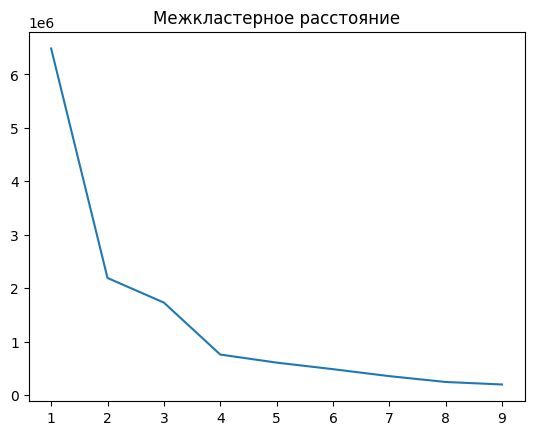

In [9]:
sns.lineplot(x=range(1, 10), y=inertias)
plt.title('Межкластерное расстояние')

По графику видно, что после 3 кластеров стремительное уменьшение инерции заканчивается, будем искать 4 кластера.

## 1 метод кластеризации: KMeans

### Обучение

In [10]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans_labels = kmeans.predict(X)

### Вычисление метрик

In [11]:
# Индекс Дэвиса-Болдина.
print(f'Индекс Дэвиса-Болдина: {davies_bouldin_score(X, kmeans_labels)}')

# Индекс Калинского-Харабаша
print(f'Индекс Калинского-Харабаша: {calinski_harabasz_score(X, kmeans_labels)}')

# Коэффициент силуэта
indx = [np.random.randint(0, len(X)) for _ in range(50000)]
print(f'Коэффициент силуэта: {silhouette_score(X.iloc[indx], kmeans_labels[indx])}')

Индекс Дэвиса-Болдина: 0.1956656621622993
Индекс Калинского-Харабаша: 93221982.21382602
Коэффициент силуэта: 0.8249180720596212


### Визуализация

Для возможности визуализации снизим размерность до 2 осей методом PCA.

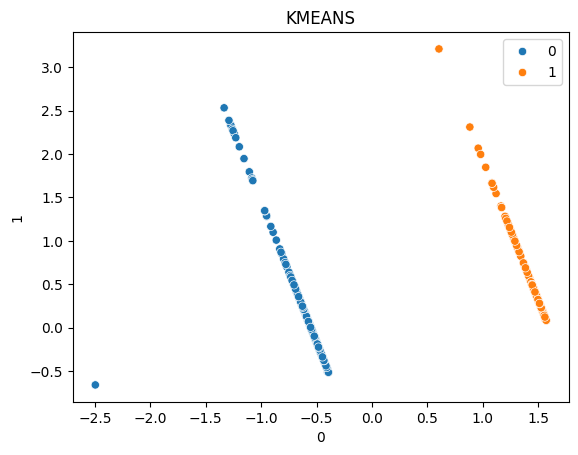

In [12]:
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(X))
# При 55 миллионах значений визуализация займет много времени, берем случайных 100.000 значений
indx = [np.random.randint(0, len(X)) for _ in range(1000)]
sns.scatterplot(data=pca_data.iloc[indx], x=0, y=1, hue=kmeans_labels[indx]);
plt.title('KMEANS');

## 2 метод кластеризации: MiniBatchKMeans

### Обучение

In [13]:
kmeansMB = MiniBatchKMeans(n_clusters=3)
kmeansMB.fit(X)
kmeansMB_labels = kmeansMB.predict(X)

### Вычисление метрик

In [14]:
# Индекс Дэвиса-Болдина.
print(f'Индекс Дэвиса-Болдина: {davies_bouldin_score(X, kmeansMB_labels)}')

# Индекс Калинского-Харабаша
print(f'Индекс Калинского-Харабаша: {calinski_harabasz_score(X, kmeansMB_labels)}')

# Коэффициент силуэта
indx = [np.random.randint(0, len(X)) for _ in range(50000)]
print(f'Коэффициент силуэта: {silhouette_score(X.iloc[indx], kmeansMB_labels[indx])}')

Индекс Дэвиса-Болдина: 0.5299941085413308
Индекс Калинского-Харабаша: 24232789.36931005
Коэффициент силуэта: 0.7944189059301409


### Визуализация

Для возможности визуализации снизим размерность до 2 осей методом PCA.

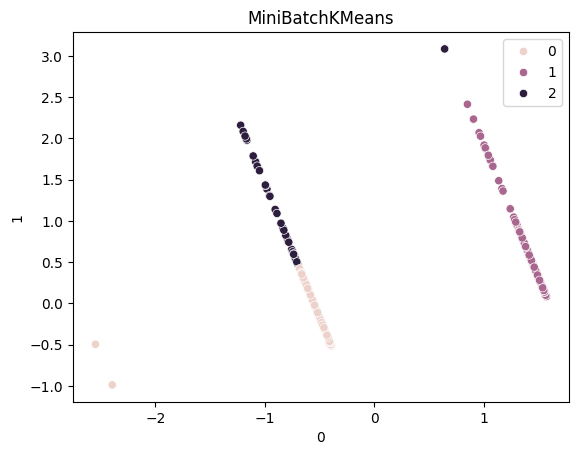

In [15]:
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(X))
# При 55 миллионах значений визуализация займет много времени, берем случайных 100.000 значений
indx = [np.random.randint(0, len(X)) for _ in range(1000)]
sns.scatterplot(data=pca_data.iloc[indx], x=0, y=1, hue=kmeansMB_labels[indx]);
plt.title('MiniBatchKMeans');

## 3 метод кластеризации: Birch

### Обучение

In [16]:
# Для замера метрик возьмем лишь часть данных, так как этот метод очень ресурсозатратный, 
# если у метода будет лучшая метрика, кластеризируем все данные
data_for_birch = X.sample(frac=0.05)
birch = Birch(n_clusters=3)
birch.fit(data_for_birch)
birch_labels = birch.predict(data_for_birch)

### Вычисление метрик

In [17]:
# Индекс Дэвиса-Болдина.
print(f'Индекс Дэвиса-Болдина: {davies_bouldin_score(data_for_birch, birch_labels)}')

# Индекс Калинского-Харабаша
print(f'Индекс Калинского-Харабаша: {calinski_harabasz_score(data_for_birch, birch_labels)}')

# Коэффициент силуэта
indx = [np.random.randint(0, len(data_for_birch)) for _ in range(50000)]
print(f'Коэффициент силуэта: {silhouette_score(data_for_birch.iloc[indx], birch_labels[indx])}')

Индекс Дэвиса-Болдина: 0.28005310251039944
Индекс Калинского-Харабаша: 16386302.861724451
Коэффициент силуэта: 0.9100946783855101


### Визуализация

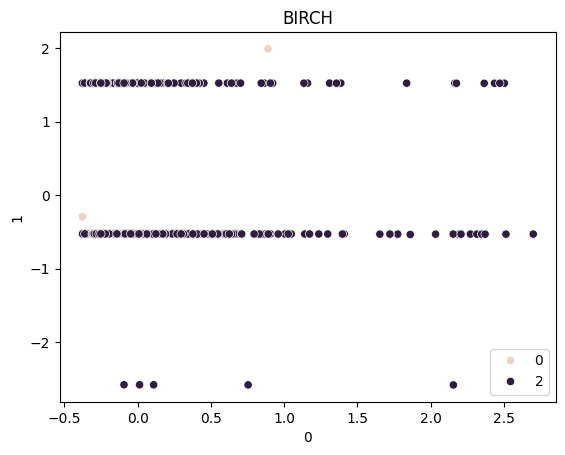

In [18]:
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(data_for_birch))
# При 55 миллионах значений визуализация займет много времени, берем случайных 100.000 значений
indx = [np.random.randint(0, len(data_for_birch)) for _ in range(1000)]
sns.scatterplot(data=pca_data.iloc[indx], x=0, y=1, hue=birch_labels[indx]);
plt.title('BIRCH');

## Лучший алгоритм - ...
В 2 метриках из трех он показал лучшее качество.<br>
Визуально он лучше всего разделил данные.<br>
Возмем метки этого кластера для дальнейшего анализа.

In [19]:
taxi = taxi.iloc[X.index]
taxi['cluster'] = kmeansMB_labels

## Описание кластеров по годам

In [20]:
taxi[taxi['year'] == 2019].groupby('cluster').mean()

,payment_type,tolls_amount,total_amount,fare_amount,trip_distance,improvement_surcharge,day,month,year
cluster,,,,,,,,,
0,1.0,0.000495,16.233856,10.295506,1.869710,0.299891,15.423491,7.912468,2019.0
1,2.0,0.001563,14.198022,10.945910,2.195798,0.298830,15.716572,7.905399,2019.0
2,1.054551,0.039577,44.154984,35.319233,10.947557,0.299945,15.531811,7.885678,2019.0


In [21]:
taxi[taxi['year'] == 2020].groupby('cluster').mean()

,payment_type,tolls_amount,total_amount,fare_amount,trip_distance,improvement_surcharge,day,month,year
cluster,,,,,,,,,
0,1.0,0.000709,15.735058,9.950942,1.917253,0.299885,15.042410,6.952431,2020.0
1,2.0,0.001795,13.448425,10.261726,2.222918,0.297710,15.116841,6.907847,2020.0
2,1.045491,0.054770,42.087242,34.932133,10.597021,0.299901,15.191738,7.007380,2020.0


In [22]:
taxi[taxi['year'] == 2021].groupby('cluster').mean()

,payment_type,tolls_amount,total_amount,fare_amount,trip_distance,improvement_surcharge,day,month,year
cluster,,,,,,,,,
0,0.972101,0.000614,16.518082,10.448427,2.020150,0.299891,15.539912,8.545183,2021.0
1,2.0,0.001602,14.269758,10.941365,2.320410,0.297514,15.749593,8.497406,2021.0
2,0.947485,0.042793,44.914207,36.052361,11.093294,0.299932,15.706447,8.553589,2021.0


#### Устойчивые закономерности:
1. total_amount в 2020 году уменьшение для всех кластеров по сравнению с 2019 годом, со временем в 2021 году опять возвращается и даже выше чем результат 2019 
2. trip_distance похожий результат, в 2020 году люди ездят меньше по сравнению с 2019 годом, но в 2021 поздки увеличиваются до уровня 2019 года с некоторым дальнейшим ростом<br>


Подозреваю, что данные закономерности связаны с пандемией COVID-19.

# 2.5 Подготовка отчета
В ходе выполнения было выполнено следующее:
- Построена аналитическая система, продемонстрирована экспертам
- Выбрана модель и проведена кластеризация набора данных
- Вычислены показатели производительности кластеризации
- Подготовлен отчет

In [24]:
taxi.to_csv('taxi.csv', index=False)